# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [1]:
DATA_DIR = '/data'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [2]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

FileNotFoundError: [Errno 2] No such file or directory: '/data/train'

In [ ]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [ ]:
!unzip "/content/train/train.zip" -d "/content/train/"
!unzip "/content/test/test.zip" -d "/content/test/"

# Data Prep

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#import lightgbm
#from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

# Modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier #Stohastic gradient descent
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier


import math

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [3]:
#!pip install lightgbm

In [3]:
from os import path
import sys
sys.path.append(path.abspath('../')) #replace this path with your own path
from custom_python_functions.model_evaluation import (
    train_crossval_predict_score,
    predict_and_print_scores,
    plot_confusion_matrix,
    plot_distributions,
    plot_correlation,
    plot_roc_curves,
    find_roc_threshold_tpr,
    find_roc_threshold_fpr,
    find_roc_threshold_accuracy,
    find_roc_threshold_f1
    )

## Read the Data

In [158]:
import pandas as pd

client_train = pd.read_csv('data/train/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('data/train/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('data/test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('data/SampleSubmission.csv', low_memory=False)

Columns:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0

- Tarif_type: Type of tax
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Months_number: Month number
- Counter_type: Type of counter

## Data Understanding

In [159]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [160]:
#print top rows of dataset
invoice_train.head(10)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
5,train_Client_0,2017-07-17,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,ELEC
6,train_Client_0,2018-12-07,11,1335667,0,207,9,1,541,0,0,0,15952,16493,12,ELEC
7,train_Client_0,2019-03-19,11,1335667,0,207,9,1,585,0,0,0,16493,17078,8,ELEC
8,train_Client_0,2011-07-22,11,1335667,0,203,9,1,1200,186,0,0,7770,9156,4,ELEC
9,train_Client_0,2011-11-22,11,1335667,0,203,6,1,1082,0,0,0,9156,10238,4,ELEC


In [161]:
client_train.head(10)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00
5,69,train_Client_10000,11,103,29/09/1993,0.00
6,62,train_Client_100000,11,309,07/06/2012,0.00
7,60,train_Client_100001,11,101,12/04/2006,0.00
8,62,train_Client_100002,11,301,31/12/2006,0.00
9,60,train_Client_100003,11,101,25/10/2011,0.00


In [162]:
client_test.head(5)

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [163]:
#print top rows of dataset
client_train.head(10)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00
5,69,train_Client_10000,11,103,29/09/1993,0.00
6,62,train_Client_100000,11,309,07/06/2012,0.00
7,60,train_Client_100001,11,101,12/04/2006,0.00
8,62,train_Client_100002,11,301,31/12/2006,0.00
9,60,train_Client_100003,11,101,25/10/2011,0.00


In [164]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,"4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00"
mean,20.13,"123,058,699,065.18",172.49,7.32,1.00,410.98,109.32,20.31,52.93,"17,767.00","18,349.70",44.83
std,13.47,"1,657,267,274,261.93",133.89,1.57,0.31,757.31,"1,220.12",157.42,875.47,"40,366.93","40,953.21","3,128.34"
min,8.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,11.00,"121,108.00",5.00,6.00,1.00,79.00,0.00,0.00,0.00,"1,791.00","2,056.00",4.00
50%,11.00,"494,561.00",203.00,8.00,1.00,274.00,0.00,0.00,0.00,"7,690.00","8,192.00",4.00
75%,40.00,"1,115,161.00",207.00,9.00,1.00,600.00,0.00,0.00,0.00,"21,660.00","22,343.00",4.00
max,45.00,"27,981,145,458,733.00",600.00,413.00,50.00,"999,910.00","999,073.00","64,492.00","547,946.00","2,800,280.00","2,870,972.00","636,624.00"


In [165]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,"135,493.00","135,493.00","135,493.00","135,493.00"
mean,63.51,11.51,206.16,0.06
std,3.35,4.42,104.21,0.23
min,60.00,11.00,101.00,0.00
25%,62.00,11.00,103.00,0.00
50%,62.00,11.00,107.00,0.00
75%,69.00,11.00,307.00,0.00
max,69.00,51.00,399.00,1.00


In [166]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [167]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [168]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [169]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [170]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [171]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

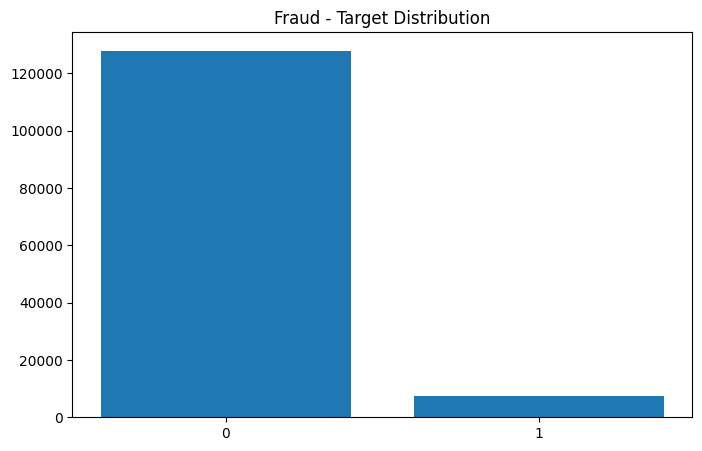

In [172]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

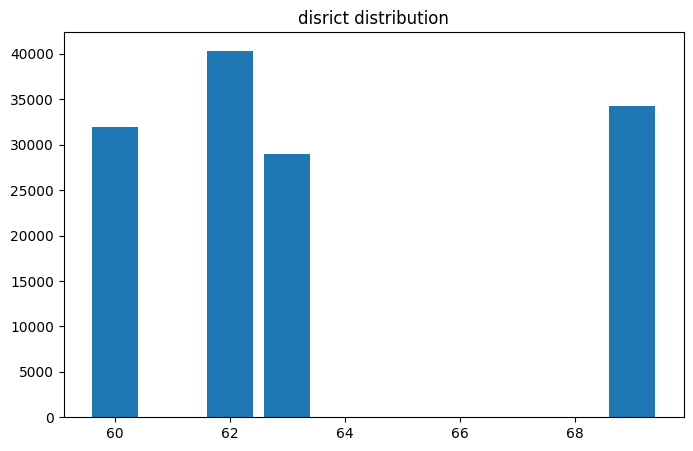

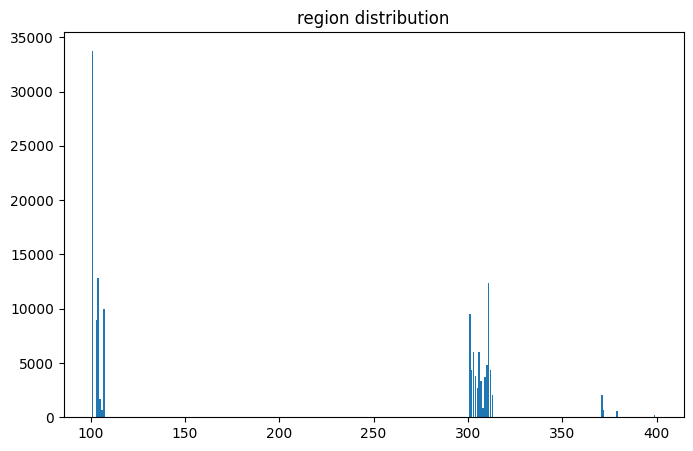

In [173]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [197]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [198]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)

In [199]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

In [200]:
def aggregate_by_client_id(invoice_data):
    aggs = {} #define aggregation dictionary
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs) #invoice data is grouped by the client id and aggregated using the dict. aggs
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values] #new dataframe where each row represents a unique client_id and contains a mean of a consumption level specified
    #above the columns of agg_trans are renamed. This renaming concatenates the original column names (which are multi-level after the aggregation operation) into single-level column names by joining them with an underscore
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id') 
            .size()
            .reset_index(name='{}transactions_count'.format('1')))#we group the original invoice_data by client_id to count the number of transactions per client

    return pd.merge(df, agg_trans, on='client_id', how='left')#we merge the transaction count df with the counsumption level averages df agg_trans on client_id column

In [201]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)
#this will again compute the mean values of consommation_level_* grouped by client_id, rename the columns to consommation_level_*_mean, count the number of transactions for each client in invoce_data
#and merge these two sets of data (average consumption levels and transaction counts) into a single df

In [202]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.40,10.57,0.00,0.00
1,train_Client_1,37,557.54,0.00,0.00,0.00
2,train_Client_10,18,798.61,37.89,0.00,0.00
3,train_Client_100,20,1.20,0.00,0.00,0.00
4,train_Client_1000,14,663.71,104.86,117.36,36.71


In [203]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')
train.head(10)

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,31/12/1994,0.00,35,352.40,10.57,0.00,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00,37,557.54,0.00,0.00,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00,18,798.61,37.89,0.00,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00,20,1.20,0.00,0.00,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00,14,663.71,104.86,117.36,36.71
5,69,train_Client_10000,11,103,29/09/1993,0.00,48,352.10,10.44,3.77,0.00
6,62,train_Client_100000,11,309,07/06/2012,0.00,40,280.02,6.55,0.00,0.00
7,60,train_Client_100001,11,101,12/04/2006,0.00,78,327.50,0.92,0.00,0.00
8,62,train_Client_100002,11,301,31/12/2006,0.00,2,112.50,0.00,0.00,0.00
9,60,train_Client_100003,11,101,25/10/2011,0.00,5,850.80,"1,629.20",320.00,"4,882.00"


## Train - Test Split

In [229]:
#drop redundant columns
sub_client_id = train['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)

NameError: name 'train' is not defined

In [230]:
y = train['target']
X = train.drop('target', axis=1)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

NameError: name 'train' is not defined

In [271]:
X_train_base.shape, X_test_base.shape

((108394, 8), (27099, 8))

## Baseline

In [207]:
consumption_all = X_train.eval('consommation_level_1_mean + consommation_level_2_mean + consommation_level_3_mean + consommation_level_4_mean')
median_consumption = consumption_all.median()

# Generate binary predictions based on the median consumption
y_train_pred = (consumption_all > median_consumption).astype(int)

# For the test set, ensure to calculate the consumption sum using test set features
consumption_test = X_test.eval('consommation_level_1_mean + consommation_level_2_mean + consommation_level_3_mean + consommation_level_4_mean')
y_test_pred = (consumption_test > median_consumption).astype(int)

# Calculate metrics
metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

metrics_df = pd.DataFrame(metrics, index=["Baseline"])
print(metrics_df)

          Accuracy  Recall  Precision  F1-score
Baseline      0.51    0.57       0.06      0.11


## LGBM Classifier

#### 2nd Baseline model: LGBMClassifier without hyperparameter optimisation

[LightGBM] [Info] Number of positive: 6053, number of negative: 102341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 108394, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055843 -> initscore=-2.827756
[LightGBM] [Info] Start training from score -2.827756
Accuracy on training set: 0.95
Accuracy on test set: 0.94
----------------------------------------
Recall on training set: 0.11
Recall on test set: 0.01
----------------------------------------
Precision on training set: 1.0
Precision on test set: 0.31
----------------------------------------
fbeta_score on training set: 0.2
fbeta_score on test set: 0.02
----------------------------------------
roc_auc_score on trainig set:  0.9
roc_auc_s

(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

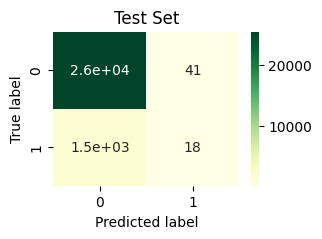

In [272]:
model_lgbmc_b = LGBMClassifier(boosting_type='gbdt', num_iterations=500)

model_lgbmc_b.fit(X_train_base, y_train_base)

y_train_pred = model_lgbmc_b.predict(X_train_base)
y_test_pred = model_lgbmc_b.predict(X_test_base)

metrics = {
    "Accuracy": [accuracy_score(y_test_base, y_test_pred)],
    "Recall": [recall_score(y_test_base, y_test_pred)],
    "Precision": [precision_score(y_test_base, y_test_pred)],
    "F1-score": [f1_score(y_test_base, y_test_pred)]
}


metrics_lgbmc_b = pd.DataFrame(metrics, index=["lgbm"])
#print(metrics_lgbmc)

predict_and_print_scores(model_lgbmc_b, X_train_base, y_train_base, X_test_base, y_test_base)

### Cross validation LGBM

#### 3rd Baseline model: LGBMClassifier with hyperparameter optimisation (Randomized search)

In [209]:
#hyperparameters = {
#    'max_depth': [5, 7, 10, 15, 20, -1],
#    'num_leaves': [1, 5, 10, 30, 50],
#    'n_estimators': [1, 5, 10, 20, 50, 100], 
#    'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
#    'min_child_samples': [5, 10, 20, 40]
#}

# Initicalize model
#model_lgbmc_cv = LGBMClassifier(boosting_type='gbdt', objective='binary', num_iterations=1000, n_jobs=-1)

# Train, cross-validate, predict, score
#best_model_lgbmc_cv = train_crossval_predict_score(model_lgbmc_cv,
#                                                   hyperparameters,    
#                                                   X_train,
#                                                   y_train,
#                                                   X_test,
#                                                   y_test,
#                                                   cv=5,
#                                                   scoring='f1',
#                                                   verbose=0,
#                                                   n_jobs=-1,
#                                                   cross_val='random',
#                                                   training=True,
#                                                   test=True,
#                                                   accuracy=True,
#                                                   recall=True,
#                                                   precision=True,
#                                                   fbeta=[True, 1.0],
#                                                   roc_auc=True,
#                                                   matrix=True,
#                                                   figsize=(3,2),
#                                                   cmap='YlGn')

In [210]:
#Best params: {'num_leaves': 30, 'n_estimators': 1, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 10, 'boosting_type': 'gbdt'}
#Best params: {'num_leaves': 50, 'n_estimators': 5, 'min_child_samples': 10, 'max_depth': 7, 'learning_rate': 10}
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')


model_lgbmc_cv = LGBMClassifier(boosting_type='gbdt',
                                objective='binary',
                                num_iterations=1,
                                n_jobs=-1,
                                max_depth=5,
                                num_leaves=30,
                                n_estimators=1, 
                                learning_rate=10,
                                min_child_samples=20
                               )

model_lgbmc_cv.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6053, number of negative: 102341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 108394, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055843 -> initscore=-2.827756
[LightGBM] [Info] Start training from score -2.827756


LGBMClassifier(learning_rate=10, max_depth=5, n_estimators=1, n_jobs=-1,
               num_iterations=1, num_leaves=30, objective='binary')

In [211]:
y_pred = model_lgbmc_cv.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("F1-score: {:.2f}".format(f1_score(y_test, y_pred)))

Accuracy: 0.67
Recall: 0.66
Precision: 0.11
F1-score: 0.18


Accuracy on training set: 0.67
Accuracy on test set: 0.67
----------------------------------------
Recall on training set: 0.68
Recall on test set: 0.66
----------------------------------------
Precision on training set: 0.11
Precision on test set: 0.11
----------------------------------------
fbeta_score on training set: 0.19
fbeta_score on test set: 0.18
----------------------------------------
roc_auc_score on trainig set:  0.74
roc_auc_score on test set:  0.73
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

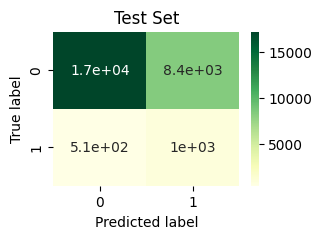

In [212]:
predict_and_print_scores(model_lgbmc_cv, X_train, y_train, X_test, y_test)

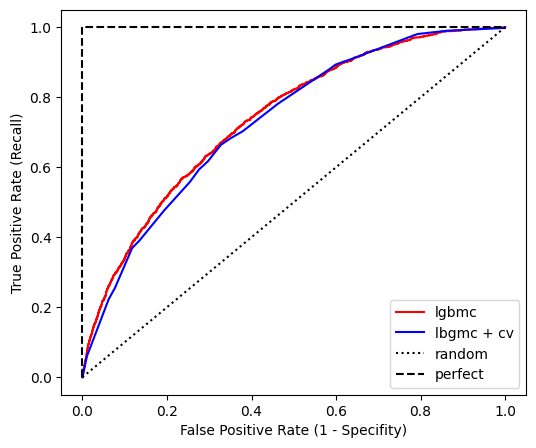

(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='False Positive Rate (1 - Specifity)', ylabel='True Positive Rate (Recall)'>)

In [213]:
# Evaluate your model
model_dic={'lgbmc' : [model_lgbmc_b, 'r-'], 'lbgmc + cv' : [model_lgbmc_cv, 'b-']}
plot_roc_curves(model_dic, X_test, y_test)

## Feature engineering

In [418]:
client = pd.read_csv('data/train/client_train.csv')
invoice = pd.read_csv('data/train/invoice_train.csv')

In [419]:
#rename columns
client.rename(columns={
    'disrict': 'district',
}, inplace=True)

invoice.rename(columns={
    'counter_statue': 'counter_status',
    'reading_remarque': 'agent_remark',
    # Add more columns as needed
}, inplace=True)

In [420]:
# Convert to categories for eda viszualizations

# List of columns to convert to categorical
columns_to_convert = ['tarif_type', 'counter_code', 'months_number', 'counter_type']

# Convert each column in invoice
for column in columns_to_convert:
    invoice[column] = invoice[column].astype('category')

In [421]:
# List of columns to convert to categorical
columns_to_convert = ['client_id', 'region','district']

# Convert each column in client
for column in columns_to_convert:
    client[column] = client[column].astype('category')

In [422]:
# convert columns to integer, ensuring support for NaN values
columns_to_convert = ['target']

# Convert each column in client to a pandas nullable integer type
for column in columns_to_convert:
    client[column] = client[column].astype('int32')

In [423]:
# change strings in counter_status to integers

def convert_to_int(value):
    # Check if the value is 'A' and return 500
    if value == 'A':
        return 500
    # Try to convert numeric strings directly to int
    try:
        return int(value)
    # If conversion fails (which shouldn't happen with the given conditions), return the value
    except ValueError:
        return value
    
invoice['counter_status'] = invoice['counter_status'].apply(convert_to_int)

In [424]:
# convert columns to integer, ensuring support for NaN values
columns_to_convert = ['counter_status','counter_code']

# Convert each column in client to a pandas nullable integer type
for column in columns_to_convert:
    invoice[column] = invoice[column].astype('int32')

In [425]:
#Change date to datetime
client['creation_date'] = pd.to_datetime(client['creation_date'])
#Change date to datetime
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])

In [426]:
#Getting unique values on the invoice train data
for col in invoice.columns:
    print(f"{col} - {invoice[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_status - 12
counter_code - 42
agent_remark - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [427]:
#Getting unique values on the client train data
for col in client.columns:
    print(f"{col} - {client[col].nunique()}")

district - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [428]:
# calculate total consumption per billing cycle per counter type

##invoice['total_consumption'] = invoice[['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']].sum(axis=1)

In [429]:
# Filter the DataFrame for rows where 'counter_type' is 'ELEC'
#change: invoice_elec = invoice[invoice['counter_type'] == 'ELEC']

# Then, aggregate total_consumption by client_id and counter type (which is now only 'ELEC')
##aggregated_consumption_ener = invoice.groupby('client_id')['total_consumption'].agg(
   ## ener_total_consumption='sum',  # Aggregate the total
    ##ener_min_consumption='min',
   ## ener_max_consumption='max',
    ##ener_mean_consumption='mean',
   ## ener_std_consumption='std',
   ## ener_range_consumption=lambda x: x.max() - x.min()  # Calculate the range as max - min
##).reset_index()

# Display the aggregated consumption for 'ELEC' counter type
##aggregated_consumption_ener

In [430]:
# Filter the DataFrame for rows where 'counter_type' is 'GAZ'
###invoice_gas = invoice[invoice['counter_type'] == 'GAZ']

# Then, aggregate total_consumption by client_id and counter type (which is now only 'ELEC')
###aggregated_consumption_gas = invoice_gas.groupby('client_id')['total_consumption'].agg(
  ###  gas_total_consumption='sum',  # Aggregate the total
  ###  gas_min_consumption='min',
  ###  gas_max_consumption='max',
  ###  gas_mean_consumption='mean',
  ###  gas_std_consumption='std',
    #gas_range_consumption=lambda x: x.max() - x.min()  # Calculate the range as max - min
###).reset_index()

# Display the aggregated consumption for 'ELEC' counter type
#aggregated_consumption_gas

In [465]:
invoice['invoice_month'] = invoice['invoice_date'].dt.month
invoice['invoice_year'] = invoice['invoice_date'].dt.year

In [466]:
# Assuming 'invoice' DataFrame is already filtered for 'ELEC' counter type
# invoice_elec = invoice[invoice['counter_type'] == 'ELEC']

# Then, aggregate consumption by client_id for each consumption level separately
aggregated_consumption_ener_1 = invoice.groupby('client_id')['consommation_level_1'].agg(
    cons1_total='sum',
    cons1_min='min',
    cons1_max='max',
    cons1_mean='mean',
    cons1_std='std',
    cons1_range=lambda x: x.max() - x.min()
).reset_index()

aggregated_consumption_ener_2 = invoice.groupby('client_id')['consommation_level_2'].agg(
    cons2_total='sum',
    cons2_min='min',
    cons2_max='max',
    cons2_mean='mean',
    cons2_std='std',
    cons2_range=lambda x: x.max() - x.min()
).reset_index()

aggregated_consumption_ener_3 = invoice.groupby('client_id')['consommation_level_3'].agg(
    cons3_total='sum',
    cons3_min='min',
    cons3_max='max',
    cons3_mean='mean',
    cons3_std='std',
    cons3_range=lambda x: x.max() - x.min()
).reset_index()

aggregated_consumption_ener_4 = invoice.groupby('client_id')['consommation_level_4'].agg(
    cons4_total='sum',
    cons4_min='min',
    cons4_max='max',
    cons4_mean='mean',
    cons4_std='std',
    cons4_range=lambda x: x.max() - x.min()
).reset_index()

In [467]:
invoice['counter_status'] = invoice['counter_status'].replace(500, 6)

invoice['counter_status'] = invoice['counter_status'].replace(769, 7)

invoice['counter_status'] = invoice['counter_status'].replace(618, 8)

invoice['counter_status'] = invoice['counter_status'].replace(269375, 9)

invoice['counter_status'] = invoice['counter_status'].replace(46, 10)

invoice['counter_status'] = invoice['counter_status'].replace(420, 11)

In [468]:
invoice['counter_status'].unique()

array([ 0,  1,  5,  4,  3,  2,  7,  6,  8,  9, 10, 11], dtype=int32)

In [469]:
aggregated_counter_status = invoice.groupby('client_id')['counter_status'].agg(
    counter_status_min='min',
    counter_status_max='max',
    counter_status_mean='mean',
    counter_status_std='std',
    #counter_status_mode='most_frequent'
).reset_index()

aggregated_counter_status

,client_id,counter_status_min,counter_status_max,counter_status_mean,counter_status_std
0,train_Client_0,0,0,0.00,0.00
1,train_Client_1,0,0,0.00,0.00
2,train_Client_10,0,0,0.00,0.00
3,train_Client_100,0,0,0.00,0.00
4,train_Client_1000,0,0,0.00,0.00
...,...,...,...,...,...
135488,train_Client_99995,0,5,0.07,0.59
135489,train_Client_99996,0,5,0.27,0.84
135490,train_Client_99997,0,0,0.00,0.00
135491,train_Client_99998,0,0,0.00,0.00


In [470]:
invoice['agent_remark'] = invoice['agent_remark'].replace(5, 1)
invoice['agent_remark'] = invoice['agent_remark'].replace(6, 2)
invoice['agent_remark'] = invoice['agent_remark'].replace(7, 3)
invoice['agent_remark'] = invoice['agent_remark'].replace(8, 4)
invoice['agent_remark'] = invoice['agent_remark'].replace(9, 5)
invoice['agent_remark'] = invoice['agent_remark'].replace(203, 6)
invoice['agent_remark'] = invoice['agent_remark'].replace(207, 7)
invoice['agent_remark'] = invoice['agent_remark'].replace(413, 8)

In [471]:
aggregated_agent_remark = invoice.groupby('client_id')['agent_remark'].agg(
    agent_remark_min='min',
    agent_remark_max='max',
    agent_remark_mean='mean',
    agent_remark_std='std',
    #agent_remark_mode='mode'
).reset_index()

aggregated_agent_remark

,client_id,agent_remark_min,agent_remark_max,agent_remark_mean,agent_remark_std
0,train_Client_0,1,4,2.29,1.02
1,train_Client_1,1,4,2.03,0.99
2,train_Client_10,1,4,2.39,1.09
3,train_Client_100,1,2,1.95,0.22
4,train_Client_1000,1,4,1.43,1.09
...,...,...,...,...,...
135488,train_Client_99995,2,2,2.00,0.00
135489,train_Client_99996,1,2,1.17,0.38
135490,train_Client_99997,1,1,1.00,0.00
135491,train_Client_99998,1,2,1.50,0.71


In [472]:
aggregated_counter_coefficient = invoice.groupby('client_id')['counter_coefficient'].agg(
    counter_coefficient_min='min',
    counter_coefficient_max='max',
    counter_coefficient_mean='mean',
    counter_coefficient_std='std',
   # counter_coefficient_remark_mode='mode'
).reset_index()

aggregated_counter_coefficient

,client_id,counter_coefficient_min,counter_coefficient_max,counter_coefficient_mean,counter_coefficient_std
0,train_Client_0,1,1,1.00,0.00
1,train_Client_1,1,1,1.00,0.00
2,train_Client_10,1,1,1.00,0.00
3,train_Client_100,1,1,1.00,0.00
4,train_Client_1000,1,1,1.00,0.00
...,...,...,...,...,...
135488,train_Client_99995,1,1,1.00,0.00
135489,train_Client_99996,1,1,1.00,0.00
135490,train_Client_99997,1,1,1.00,0.00
135491,train_Client_99998,1,1,1.00,0.00


In [473]:
aggregated_counter_code = invoice.groupby('client_id')['counter_code'].agg(
    counter_code_min='min',
    counter_code_max='max',
    counter_code_mean='mean',
    counter_code_std='std',
   # counter_coefficient_remark_mode='mode'
).reset_index()

aggregated_counter_code

,client_id,counter_code_min,counter_code_max,counter_code_mean,counter_code_std
0,train_Client_0,203,207,203.69,1.53
1,train_Client_1,203,203,203.00,0.00
2,train_Client_10,203,207,203.22,0.94
3,train_Client_100,413,413,413.00,0.00
4,train_Client_1000,207,207,207.00,0.00
...,...,...,...,...,...
135488,train_Client_99995,5,207,110.27,101.63
135489,train_Client_99996,5,207,103.54,102.22
135490,train_Client_99997,5,207,128.44,99.87
135491,train_Client_99998,202,202,202.00,0.00


In [474]:
# add transaction counts per counter_type
#grouped_counts = invoice.groupby(['client_id']).size().reset_index(name='count')

#transaction_counts = grouped_counts.pivot(index='client_id', columns='counter_type', values='count').reset_index()

#grouped_counts = invoice.groupby(['client_id']).size().reset_index(name='transaction_count')
grouped_counts = invoice.groupby('client_id').size().reset_index(name='transaction_count')

grouped_counts

,client_id,transaction_count
0,train_Client_0,35
1,train_Client_1,37
2,train_Client_10,18
3,train_Client_100,20
4,train_Client_1000,14
...,...,...
135488,train_Client_99995,71
135489,train_Client_99996,41
135490,train_Client_99997,36
135491,train_Client_99998,2


In [475]:
# group by the relevant columns and count the occurrences.
tarif_freq = invoice.groupby(['client_id', 'counter_type']).size().reset_index(name='freq')

# Identify the max frequency per client_id and counter_type
max_freq = tarif_freq.groupby(['client_id', 'counter_type'])['freq'].transform(max) == tarif_freq['freq']

# Apply the filter
tarif_freq_max = tarif_freq[max_freq]

# In case of ties, we'll keep the first occurrence
tarif_freq_max = tarif_freq_max.drop_duplicates(subset=['client_id', 'counter_type'])

# Pivot to get separate columns for ELEC and GAZ tarif_type
tarif_pivot = tarif_freq_max.pivot(index='client_id', columns='counter_type', values='tarif_type').reset_index()

# Rename columns to 'elec_tarif' and 'gaz_tarif'
tarif_pivot.columns = ['client_id', 'elec_tarif', 'gaz_tarif']
tarif_pivot.head()

KeyError: 'tarif_type'

In [476]:
# Sort invoice DataFrame by 'client_id', 'counter_type', and 'invoice_date'
invoice_sorted = invoice.sort_values(['client_id', 'counter_type', 'invoice_date'])

# Calculate the difference in days between invoice dates within each group of 'client_id' and 'counter_type'
invoice_sorted['invoice_delta_time'] = invoice_sorted.groupby(['client_id', 'counter_type'])['invoice_date'].diff().dt.days

# Create a new DataFrame focusing on the columns of interest
date_eda = invoice_sorted[['client_id', 'counter_type', 'invoice_date', 'invoice_delta_time']].copy()

# Sort this new DataFrame by 'client_id', 'counter_type', and 'invoice_date'
date_eda_sorted = date_eda.sort_values(['client_id', 'counter_type', 'invoice_date'])

In [477]:
# Sort invoice DataFrame by 'client_id', 'counter_type', and 'invoice_date'
invoice_sorted = invoice.sort_values(['client_id', 'invoice_date'])

# Calculate the difference in days between invoice dates within each group of 'client_id' and 'counter_type'
invoice_sorted['invoice_delta_time'] = invoice_sorted.groupby(['client_id'])['invoice_date'].diff().dt.days

# Create a new DataFrame focusing on the columns of interest
date_eda = invoice_sorted[['client_id', 'invoice_date', 'invoice_delta_time']].copy()

# Sort this new DataFrame by 'client_id', 'counter_type', and 'invoice_date'
date_eda_sorted = date_eda.sort_values(['client_id', 'invoice_date'])

In [478]:
# Filter the DataFrame for rows where 'counter_type' is 'ELEC'
#date_elec = date_eda_sorted[date_eda_sorted['counter_type'] == 'ELEC' AND date_eda_sorted['counter_type'] == 'GAZ']

# Group by both 'client_id' and 'counter_type', then calculate the aggregate statistics for 'invoice_delta_time'
aggregated_ener_date_stats = date_eda_sorted.groupby(['client_id'])['invoice_delta_time'].agg(
    ener_min_invoice_delta='min',
    ener_max_invoice_delta='max',
    ener_mean_invoice_delta='mean',
    #elec_median_invoice_delta='median',
    ener_std_invoice_delta='std'
).reset_index()
aggregated_ener_date_stats

,client_id,ener_min_invoice_delta,ener_max_invoice_delta,ener_mean_invoice_delta,ener_std_invoice_delta
0,train_Client_0,40.00,508.00,144.15,87.60
1,train_Client_1,4.00,372.00,136.47,92.49
2,train_Client_10,20.00,738.00,289.47,250.70
3,train_Client_100,4.00,442.00,140.21,95.57
4,train_Client_1000,4.00,301.00,121.92,80.06
...,...,...,...,...,...
135488,train_Client_99995,0.00,250.00,72.84,72.20
135489,train_Client_99996,0.00,231.00,57.67,68.85
135490,train_Client_99997,0.00,395.00,80.60,101.50
135491,train_Client_99998,122.00,122.00,122.00,NaN


In [479]:
# Filter the DataFrame for rows where 'counter_type' is 'GAZ'
###date_gas = date_eda_sorted[date_eda_sorted['counter_type'] == 'GAZ']

# Group by both 'client_id' and 'counter_type', then calculate the aggregate statistics for 'invoice_delta_time'
###aggregated_gas_date_stats = date_gas.groupby(['client_id'])['invoice_delta_time'].agg(
###    gas_min_invoice_delta='min',
###    gas_max_invoice_delta='max',
###    gas_mean_invoice_delta='mean',
    #gas_median_invoice_delta='median',
###    gas_std_invoice_delta='std'
###).reset_index()

In [480]:
# List of columns you want to include in the new DataFrame
columns_to_include = ['client_id', 'client_catg', 'region', 'creation_date', 'target']

# Create a new DataFrame with the specified columns
model_df = client[columns_to_include].copy()

In [481]:
model_df = model_df.merge(aggregated_counter_status[['client_id',
                                                     'counter_status_min',
                                                     'counter_status_max',
                                                     'counter_status_mean',
                                                     'counter_status_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_agent_remark[['client_id',
                                                   'agent_remark_min',
                                                   'agent_remark_max',
                                                   'agent_remark_mean',
                                                   'agent_remark_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_counter_coefficient[['client_id',
                                                          'counter_coefficient_min',
                                                          'counter_coefficient_max',
                                                          'counter_coefficient_mean',
                                                          'counter_coefficient_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_counter_code[['client_id',
                                                          'counter_code_min',
                                                          'counter_code_max',
                                                          'counter_code_mean',
                                                          'counter_code_std']], on='client_id', how='left')

model_df = model_df.merge(grouped_counts[['client_id','transaction_count']], on='client_id', how='left')

#model_df = model_df.merge(tarif_pivot[['client_id', 'elec_tarif', 'gaz_tarif']], on='client_id', how='left')

In [482]:
model_df = model_df.merge(aggregated_consumption_elec[['client_id',
                                                       'ener_total_consumption',
                                                       'ener_min_consumption',
                                                       'ener_max_consumption',
                                                       'ener_mean_consumption',
                                                       'ener_std_consumption']], on='client_id', how='left')


#model_df = model_df.merge(aggregated_consumption_gas[['client_id',
                                                     # 'gas_total_consumption',
                                                     # 'gas_min_consumption',
                                                     # 'gas_max_consumption',
                                                      #'gas_mean_consumption',
                                                      #'gas_std_consumption']], on='client_id', how='left')

model_df = model_df.merge(aggregated_ener_date_stats[['client_id',
                                                      'ener_min_invoice_delta',
                                                      'ener_max_invoice_delta',
                                                      'ener_mean_invoice_delta',
                                                      'ener_std_invoice_delta']], on='client_id', how='left')

#model_df = model_df.merge(aggregated_gas_date_stats[['client_id',
#                                                     'gas_min_invoice_delta',
#                                                     'gas_max_invoice_delta',
#                                                     'gas_mean_invoice_delta',
#                                                     'gas_std_invoice_delta']], on='client_id', how='left')


model_df = model_df.merge(aggregated_consumption_ener_1[['client_id', 
                                                         'cons1_total', 
                                                         'cons1_min', 
                                                         'cons1_max', 
                                                         'cons1_mean', 
                                                         'cons1_std', 
                                                         'cons1_range']], 
                          on='client_id', 
                          how='left')


model_df = model_df.merge(aggregated_consumption_ener_2[['client_id', 
                                                         'cons2_total', 
                                                         'cons2_min', 
                                                         'cons2_max', 
                                                         'cons2_mean', 
                                                         'cons2_std', 
                                                         'cons2_range']], 
                          on='client_id', 
                          how='left')


model_df = model_df.merge(aggregated_consumption_ener_3[['client_id', 
                                                         'cons3_total', 
                                                         'cons3_min', 
                                                         'cons3_max', 
                                                         'cons3_mean', 
                                                         'cons3_std', 
                                                         'cons3_range']], 
                          on='client_id', 
                          how='left')


model_df = model_df.merge(aggregated_consumption_ener_4[['client_id', 
                                                         'cons4_total', 
                                                         'cons4_min', 
                                                         'cons4_max', 
                                                         'cons4_mean', 
                                                         'cons4_std', 
                                                         'cons4_range']], 
                          on='client_id', 
                          how='left')

In [483]:
model_df

,client_id,client_catg,region,creation_date,target,counter_status_min,counter_status_max,counter_status_mean,counter_status_std,agent_remark_min,...,cons3_max,cons3_mean,cons3_std,cons3_range,cons4_total,cons4_min,cons4_max,cons4_mean,cons4_std,cons4_range
0,train_Client_0,11,101,1994-12-31,0,0,0,0.00,0.00,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
1,train_Client_1,11,107,2002-05-29,0,0,0,0.00,0.00,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
2,train_Client_10,11,301,1986-03-13,0,0,0,0.00,0.00,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
3,train_Client_100,11,105,1996-07-11,0,0,0,0.00,0.00,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
4,train_Client_1000,11,303,2014-10-14,0,0,0,0.00,0.00,1,...,800,117.36,289.43,800,514,0,382,36.71,105.42,382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,train_Client_99995,11,304,2004-07-26,0,0,5,0.07,0.59,2,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
135489,train_Client_99996,11,311,2012-10-25,0,0,5,0.27,0.84,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
135490,train_Client_99997,11,311,2011-11-22,0,0,0,0.00,0.00,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0
135491,train_Client_99998,11,101,1993-12-22,0,0,0,0.00,0.00,1,...,0,0.00,0.00,0,0,0,0,0.00,0.00,0


In [484]:
model_df['coop_time'] = (2019 - model_df['creation_date'].dt.year)*12 - model_df['creation_date'].dt.month

In [485]:
model_df['invoice_per_cooperation'] = model_df['transaction_count'] / model_df['coop_time']
model_df['invoice_per_cooperation'].replace([np.inf, -np.inf], 0, inplace=True)

In [486]:
model_df.head(30)

,client_id,client_catg,region,creation_date,target,counter_status_min,counter_status_max,counter_status_mean,counter_status_std,agent_remark_min,...,cons3_std,cons3_range,cons4_total,cons4_min,cons4_max,cons4_mean,cons4_std,cons4_range,coop_time,invoice_per_cooperation
0,train_Client_0,11,101,1994-12-31,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,288,0.12
1,train_Client_1,11,107,2002-05-29,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,199,0.19
2,train_Client_10,11,301,1986-03-13,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,393,0.05
3,train_Client_100,11,105,1996-07-11,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,269,0.07
4,train_Client_1000,11,303,2014-10-14,0,0,0,0.00,0.00,1,...,289.43,800,514,0,382,36.71,105.42,382,50,0.28
5,train_Client_10000,11,103,1993-09-29,0,0,0,0.00,0.00,1,...,26.13,181,0,0,0,0.00,0.00,0,303,0.16
6,train_Client_100000,11,309,2012-06-07,0,0,1,0.20,0.41,1,...,0.00,0,0,0,0,0.00,0.00,0,78,0.51
7,train_Client_100001,11,101,2006-04-12,0,0,1,0.01,0.11,1,...,0.00,0,0,0,0,0.00,0.00,0,152,0.51
8,train_Client_100002,11,301,2006-12-31,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,144,0.01
9,train_Client_100003,11,101,2011-10-25,0,0,0,0.00,0.00,1,...,438.18,800,24410,0,15257,"4,882.00","7,024.67",15257,86,0.06


In [487]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   client_id                 135493 non-null  object        
 1   client_catg               135493 non-null  int64         
 2   region                    135493 non-null  category      
 3   creation_date             135493 non-null  datetime64[ns]
 4   target                    135493 non-null  int32         
 5   counter_status_min        135493 non-null  int32         
 6   counter_status_max        135493 non-null  int32         
 7   counter_status_mean       135493 non-null  float64       
 8   counter_status_std        131281 non-null  float64       
 9   agent_remark_min          135493 non-null  int64         
 10  agent_remark_max          135493 non-null  int64         
 11  agent_remark_mean         135493 non-null  float64       
 12  ag

In [488]:
columns_to_convert = ['client_catg', 'agent_remark_min', 'agent_remark_max', 'counter_coefficient_min', 'counter_coefficient_max']

for column in columns_to_convert:
    model_df[column] = model_df[column].astype('int32')

In [489]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   client_id                 135493 non-null  object        
 1   client_catg               135493 non-null  int32         
 2   region                    135493 non-null  category      
 3   creation_date             135493 non-null  datetime64[ns]
 4   target                    135493 non-null  int32         
 5   counter_status_min        135493 non-null  int32         
 6   counter_status_max        135493 non-null  int32         
 7   counter_status_mean       135493 non-null  float64       
 8   counter_status_std        131281 non-null  float64       
 9   agent_remark_min          135493 non-null  int32         
 10  agent_remark_max          135493 non-null  int32         
 11  agent_remark_mean         135493 non-null  float64       
 12  ag

In [490]:
model_df.head()

,client_id,client_catg,region,creation_date,target,counter_status_min,counter_status_max,counter_status_mean,counter_status_std,agent_remark_min,...,cons3_std,cons3_range,cons4_total,cons4_min,cons4_max,cons4_mean,cons4_std,cons4_range,coop_time,invoice_per_cooperation
0,train_Client_0,11,101,1994-12-31,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,288,0.12
1,train_Client_1,11,107,2002-05-29,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,199,0.19
2,train_Client_10,11,301,1986-03-13,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,393,0.05
3,train_Client_100,11,105,1996-07-11,0,0,0,0.00,0.00,1,...,0.00,0,0,0,0,0.00,0.00,0,269,0.07
4,train_Client_1000,11,303,2014-10-14,0,0,0,0.00,0.00,1,...,289.43,800,514,0,382,36.71,105.42,382,50,0.28


### Modeling 

In [491]:
#drop redundant columns
model_df_copy = model_df.copy()
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in model_df_copy.columns:
        model_df_copy.drop([col], axis=1, inplace=True)
        
model_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   client_catg               135493 non-null  int32   
 1   region                    135493 non-null  category
 2   target                    135493 non-null  int32   
 3   counter_status_min        135493 non-null  int32   
 4   counter_status_max        135493 non-null  int32   
 5   counter_status_mean       135493 non-null  float64 
 6   counter_status_std        131281 non-null  float64 
 7   agent_remark_min          135493 non-null  int32   
 8   agent_remark_max          135493 non-null  int32   
 9   agent_remark_mean         135493 non-null  float64 
 10  agent_remark_std          131281 non-null  float64 
 11  counter_coefficient_min   135493 non-null  int32   
 12  counter_coefficient_max   135493 non-null  int32   
 13  counter_coefficient_mean  135

### Train - Test Split 

In [492]:
y = model_df_copy['target']
X = model_df_copy.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((108394, 54), (27099, 54))

### Modeling - LGMC

Accuracy on training set: 0.94
Accuracy on test set: 0.93
----------------------------------------
Recall on training set: 0.34
Recall on test set: 0.23
----------------------------------------
Precision on training set: 0.45
Precision on test set: 0.31
----------------------------------------
fbeta_score on training set: 0.39
fbeta_score on test set: 0.26
----------------------------------------
roc_auc_score on trainig set:  0.89
roc_auc_score on test set:  0.81
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

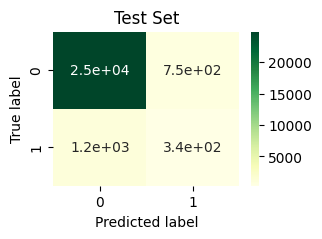

In [493]:
class_ratio = math.sqrt((y_train == 0).sum() / (y_train == 1).sum())
model_lgbmc = LGBMClassifier(boosting_type='gbdt', random_state=RSEED, scale_pos_weight=class_ratio, n_jobs=-1, verbosity=-1)

model_lgbmc.fit(X_train, y_train)

y_train_pred = model_lgbmc.predict(X_train)
y_test_pred = model_lgbmc.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}


metrics_lgbmc = pd.DataFrame(metrics, index=["lgbm"])
#print(metrics_lgbmc)

predict_and_print_scores(model_lgbmc, X_train, y_train, X_test, y_test)

In [494]:
y_pred = model_lgbmc.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("F1-score: {:.2f}".format(f1_score(y_test, y_pred)))

Accuracy: 0.93
Recall: 0.23
Precision: 0.31
F1-score: 0.26


### Pipeline for preprocessing

In [495]:
#num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
#cat_features = X_train.select_dtypes(include=['object', 'category']).columns

#cat_prep = ColumnTransformer(transformers=[
#    ('encoder', OneHotEncoder(handle_unknown='error', drop='first', sparse_output=False), cat_features)
#], remainder='passthrough')

In [496]:
from sklearn.preprocessing import PolynomialFeatures

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
   # ('poly', PolynomialFeatures(degree=2, include_bias=False)) 
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    #('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    remainder='passthrough')

In [497]:
#class_ratio = math.sqrt((y_train == 0).sum() / (y_train == 1).sum())

lgbmc_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('oversample', RandomUnderSampler(sampling_strategy=0.5)),
    ('lgbmc', LGBMClassifier(boosting_type='gbdt', random_state=RSEED, scale_pos_weight=class_ratio, n_jobs=-1, verbosity=-1))
]) 

Accuracy on training set: 0.55
Accuracy on test set: 0.55
----------------------------------------
Recall on training set: 0.98
Recall on test set: 0.87
----------------------------------------
Precision on training set: 0.11
Precision on test set: 0.1
----------------------------------------
fbeta_score on training set: 0.2
fbeta_score on test set: 0.18
----------------------------------------
roc_auc_score on trainig set:  0.88
roc_auc_score on test set:  0.8
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

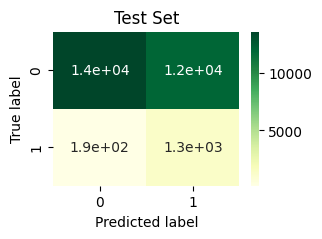

In [498]:
lgbmc_pipe.fit(X_train, y_train)

y_train_pred = lgbmc_pipe.predict(X_train)
y_test_pred = lgbmc_pipe.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

#lgbmc_pipe = pd.DataFrame(metrics, index=["lgbm"])
#print(metrics_lgbmc)

predict_and_print_scores(lgbmc_pipe, X_train, y_train, X_test, y_test)

In [499]:
y_pred = lgbmc_pipe.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("F1-score: {:.2f}".format(f1_score(y_test, y_pred)))

Accuracy: 0.55
Recall: 0.87
Precision: 0.10
F1-score: 0.18


### LGBMC Cross-Validation (Randomized search)

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4a

Best params: {'lgbmc__num_leaves': 50, 'lgbmc__n_estimators': 20, 'lgbmc__min_split_gain': 0.005, 'lgbmc__max_depth': 7, 'lgbmc__learning_rate': 1}
----------------------------------------
Accuracy on training set: 0.64
Accuracy on test set: 0.62
----------------------------------------
Recall on training set: 0.96
Recall on test set: 0.75
----------------------------------------
Precision on training set: 0.13
Precision on test set: 0.1
----------------------------------------
fbeta_score on training set: 0.23
fbeta_score on test set: 0.18
----------------------------------------
roc_auc_score on trainig set:  0.87
roc_auc_score on test set:  0.75
----------------------------------------


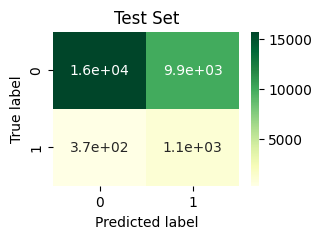

In [500]:
hyperparameters = {
    'lgbmc__max_depth': [5, 7, 10, 50, 100],
    'lgbmc__num_leaves': [1, 5, 10, 30, 50, 100, 200, 500],
    'lgbmc__n_estimators': [5, 10, 20, 50, 100, 500, 1000, 1],
    'lgbmc__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'lgbmc__min_split_gain': [0.001, 0.005, 0.01],
    #'lgbmc__feature_fraction': [0.1, 0.5, 1.0],
    #'lgbmc__bagging_freq': [0.1, 1, 10]
}
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
# Train, cross-validate, predict, score
model_lgbmc_3, params_lgbmc_3, _, _ = train_crossval_predict_score(
    lgbmc_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

In [501]:
y_pred = model_lgbmc_3.predict(X_test)

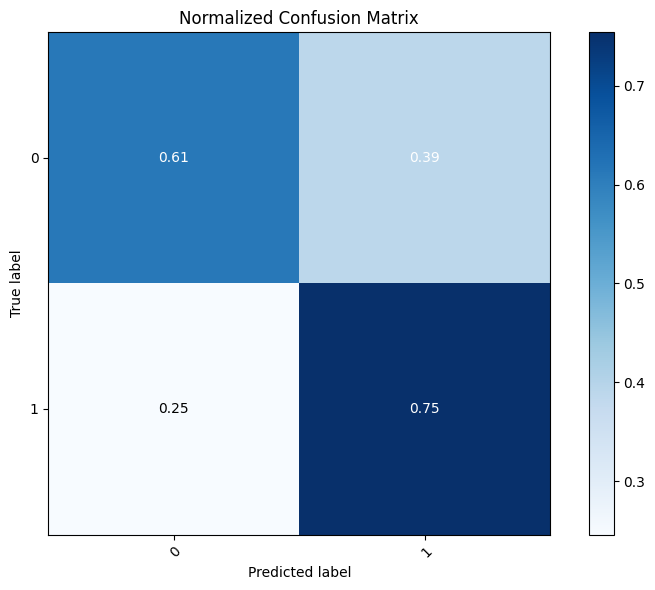

In [502]:
import numpy as np
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm_normalized.shape[1]),
       yticks=np.arange(cm_normalized.shape[0]),
       
       xticklabels=range(cm_normalized.shape[1]), yticklabels=range(cm_normalized.shape[0]),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

### Grid search

In [ ]:
hyperparameters = {
    'lgbmc__max_depth': [5, 7, 10, 50, 100],
    'lgbmc__num_leaves': [1, 5, 10, 30, 50, 100, 200, 500],
    'lgbmc__n_estimators': [5, 10, 20, 50, 100, 500, 1000, 1],
    'lgbmc__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'lgbmc__min_split_gain': [0.001, 0.005, 0.01],
    #'lgbmc__feature_fraction': [0.1, 0.5, 1.0],
    #'lgbmc__bagging_freq': [0.1, 1, 10]
}
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
# Train, cross-validate, predict, score
model_lgbmc_5, params_lgbmc_5, _, _ = train_crossval_predict_score(
    lgbmc_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='full',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4ac39c699edf05ffdaa9/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/cd/9n4m53qs44l7_xb_15rx3h1c0000gn/T/pip-install-zw7aag97/lightgbm_bf3209a729de4a

### Logistic Regression

Accuracy on training set: 0.89
Accuracy on test set: 0.89
----------------------------------------
Recall on training set: 0.19
Recall on test set: 0.19
----------------------------------------
Precision on training set: 0.15
Precision on test set: 0.15
----------------------------------------
fbeta_score on training set: 0.16
fbeta_score on test set: 0.17
----------------------------------------
roc_auc_score on trainig set:  0.67
roc_auc_score on test set:  0.68
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

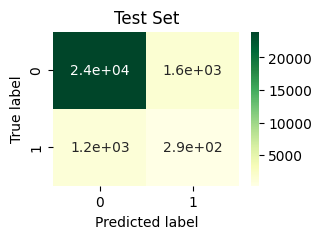

In [282]:
#class_ratio = math.sqrt((y_train == 0).sum() / (y_train == 1).sum())

lg_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('lg', LogisticRegression())
]) 

lg_pipe.fit(X_train, y_train)

y_train_pred = lg_pipe.predict(X_train)
y_test_pred = lg_pipe.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}
#lgbmc_pipe = pd.DataFrame(metrics, index=["lgbm"])
#print(metrics_lgbmc)

predict_and_print_scores(lg_pipe, X_train, y_train, X_test, y_test)

/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarni

Best params: {'lg__solver': 'liblinear', 'lg__penalty': 'l2', 'lg__max_iter': 200, 'lg__l1_ratio': 0.0, 'lg__C': 0.01}
----------------------------------------
Accuracy on training set: 0.87
Accuracy on test set: 0.87
----------------------------------------
Recall on training set: 0.27
Recall on test set: 0.26
----------------------------------------
Precision on training set: 0.14
Precision on test set: 0.15
----------------------------------------
fbeta_score on training set: 0.19
fbeta_score on test set: 0.19
----------------------------------------
roc_auc_score on trainig set:  0.72
roc_auc_score on test set:  0.72
----------------------------------------


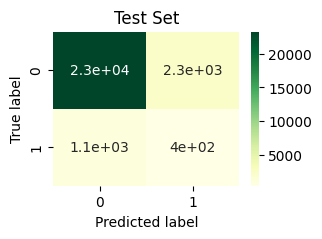

In [283]:
hyperparameters= {'lg__penalty':('l1','l2', 'elasticnet', 'none', 'l1_ratio'),
                'lg__C': [0.001, 0.01, 0.1, 1, 10],
                'lg__solver': ['liblinear','sag'],
                'lg__max_iter': [100, 200, 500, 1000],  
                'lg__l1_ratio': np.linspace(0, 1, 5) 
                 }
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
# Train, cross-validate, predict, score
model_lg_3, params_lg_3, _, _ = train_crossval_predict_score(
    lg_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

In [284]:
y_pred = model_lg_3.predict(X_test)

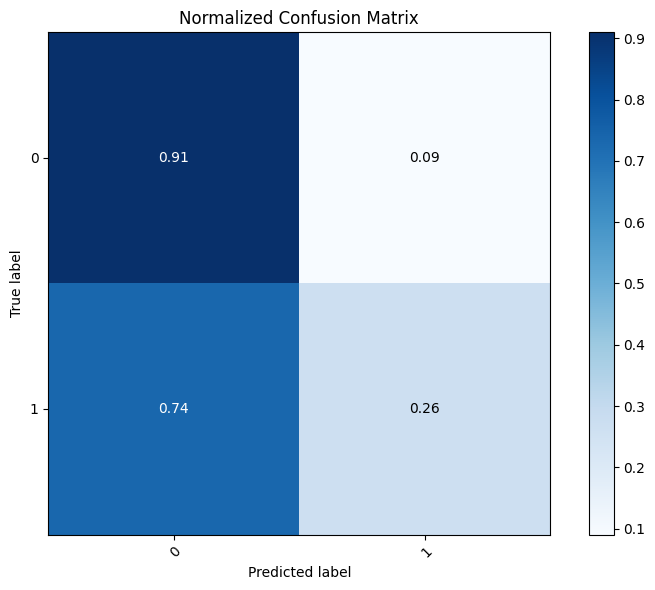

In [285]:
import numpy as np
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm_normalized.shape[1]),
       yticks=np.arange(cm_normalized.shape[0]),
       
       xticklabels=range(cm_normalized.shape[1]), yticklabels=range(cm_normalized.shape[0]),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

## XGBoost

Accuracy on training set: 0.86
Accuracy on test set: 0.83
----------------------------------------
Recall on training set: 0.83
Recall on test set: 0.53
----------------------------------------
Precision on training set: 0.26
Precision on test set: 0.17
----------------------------------------
fbeta_score on training set: 0.4
fbeta_score on test set: 0.26
----------------------------------------
roc_auc_score on trainig set:  0.93
roc_auc_score on test set:  0.79
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

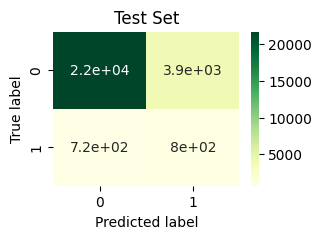

In [503]:
xgb_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

xgb_pipe.fit(X_train, y_train)

y_train_pred = xgb_pipe.predict(X_train)
y_test_pred = xgb_pipe.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

# Assuming the function predict_and_print_scores is defined to print or return metrics
predict_and_print_scores(xgb_pipe, X_train, y_train, X_test, y_test)

Best params: {'xgb__subsample': 0.5, 'xgb__n_estimators': 500, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.5}
----------------------------------------
Accuracy on training set: 0.85
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.6
Recall on test set: 0.5
----------------------------------------
Precision on training set: 0.21
Precision on test set: 0.18
----------------------------------------
fbeta_score on training set: 0.32
fbeta_score on test set: 0.26
----------------------------------------
roc_auc_score on trainig set:  0.85
roc_auc_score on test set:  0.8
----------------------------------------


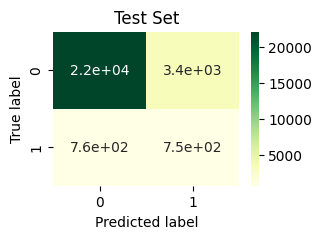

In [504]:
hyperparameters = {
    'xgb__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'xgb__n_estimators': [100, 200, 500, 600],
    'xgb__max_depth': [3, 5, 7, 10, 15, 20, 25],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
}
model_xgb_5, params_xgb_5, _, _ = train_crossval_predict_score(
    xgb_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

## Grid search 

Best params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 600, 'xgb__subsample': 0.7}
----------------------------------------
Accuracy on training set: 0.87
Accuracy on test set: 0.86
----------------------------------------
Recall on training set: 0.65
Recall on test set: 0.49
----------------------------------------
Precision on training set: 0.26
Precision on test set: 0.2
----------------------------------------
fbeta_score on training set: 0.37
fbeta_score on test set: 0.28
----------------------------------------
roc_auc_score on trainig set:  0.89
roc_auc_score on test set:  0.81
----------------------------------------


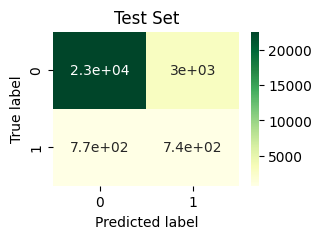

In [508]:
hyperparameters = {
    'xgb__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'xgb__n_estimators': [100, 200, 500, 600],
    'xgb__max_depth': [3, 5, 7, 10, 15, 20, 25],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
}
model_xgb_6, params_xgb_6, _, _ = train_crossval_predict_score(
    xgb_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='full',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

Best params: {'xgb__subsample': 0.7, 'xgb__n_estimators': 500, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.7}

Best params: {'xgb__subsample': 0.7, 'xgb__n_estimators': 600, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.5}

Grid search:
Best params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 600, 'xgb__subsample': 0.7}

Accuracy on training set: 0.88
Accuracy on test set: 0.86
----------------------------------------
Recall on training set: 0.82
Recall on test set: 0.5
----------------------------------------
Precision on training set: 0.3
Precision on test set: 0.2
----------------------------------------
fbeta_score on training set: 0.44
fbeta_score on test set: 0.28
----------------------------------------
roc_auc_score on trainig set:  0.94
roc_auc_score on test set:  0.81
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

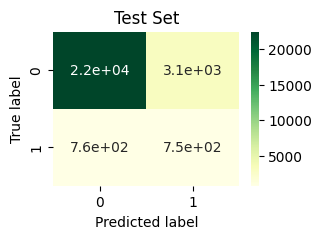

In [519]:
#model_xgb_3, params_xgb_3
#model_xgb_3.fit(X_train, y_train)

xgb_best_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('best_xgb', XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.01, colsample_bytree=0.7,
                       subsample=0.7, use_label_encoder=False))
])

xgb_best_pipe.fit(X_train, y_train)
y_train_pred = xgb_best_pipe.predict(X_train)
y_test_pred = xgb_best_pipe.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

# Assuming the function predict_and_print_scores is defined to print or return metrics
predict_and_print_scores(xgb_best_pipe, X_train, y_train, X_test, y_test)

Accuracy on training set: 0.87
Accuracy on test set: 0.86
----------------------------------------
Recall on training set: 0.65
Recall on test set: 0.5
----------------------------------------
Precision on training set: 0.25
Precision on test set: 0.19
----------------------------------------
fbeta_score on training set: 0.36
fbeta_score on test set: 0.28
----------------------------------------
roc_auc_score on trainig set:  0.88
roc_auc_score on test set:  0.81
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

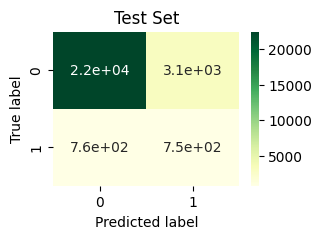

In [515]:
#model_xgb_3, params_xgb_3
#model_xgb_3.fit(X_train, y_train)

xgb_best_grid = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('best_xgb', XGBClassifier(n_estimators=600, max_depth=7, learning_rate=0.01, colsample_bytree=1,
                       subsample=0.7, use_label_encoder=False))
])

xgb_best_grid.fit(X_train, y_train)
y_train_pred = xgb_best_grid.predict(X_train)
y_test_pred = xgb_best_grid.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

# Assuming the function predict_and_print_scores is defined to print or return metrics
predict_and_print_scores(xgb_best_grid, X_train, y_train, X_test, y_test)

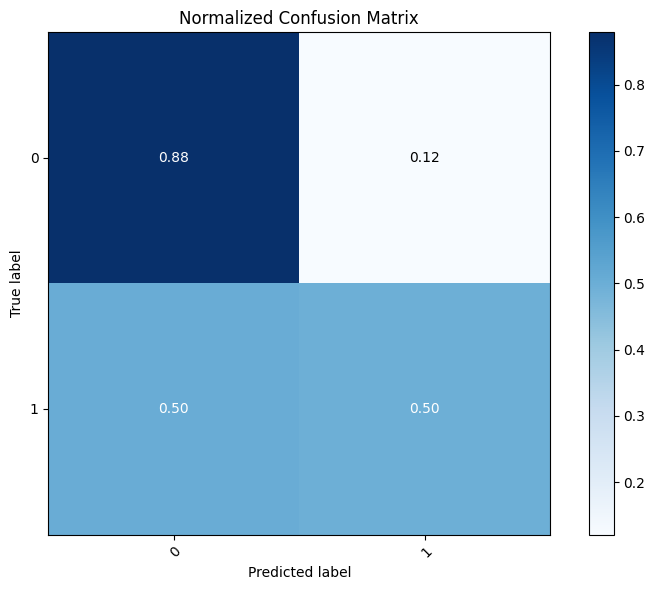

In [520]:
import numpy as np
cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm_normalized.shape[1]),
       yticks=np.arange(cm_normalized.shape[0]),
       
       xticklabels=range(cm_normalized.shape[1]), yticklabels=range(cm_normalized.shape[0]),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

### Random forest

Accuracy on training set: 0.9
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 1.0
Recall on test set: 0.44
----------------------------------------
Precision on training set: 0.35
Precision on test set: 0.18
----------------------------------------
fbeta_score on training set: 0.52
fbeta_score on test set: 0.25
----------------------------------------
roc_auc_score on trainig set:  0.99
roc_auc_score on test set:  0.78
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

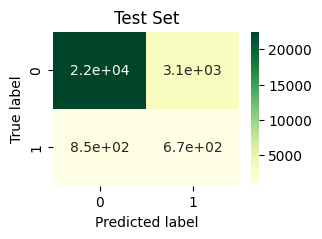

In [507]:
rf_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('rf', RandomForestClassifier())  # Adjust additional parameters as needed
])

rf_pipe.fit(X_train, y_train)

y_train_pred = rf_pipe.predict(X_train)
y_test_pred = rf_pipe.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

predict_and_print_scores(rf_pipe, X_train, y_train, X_test, y_test)

Best params: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 30}
----------------------------------------
Accuracy on training set: 0.89
Accuracy on test set: 0.86
----------------------------------------
Recall on training set: 0.94
Recall on test set: 0.46
----------------------------------------
Precision on training set: 0.34
Precision on test set: 0.18
----------------------------------------
fbeta_score on training set: 0.5
fbeta_score on test set: 0.26
----------------------------------------
roc_auc_score on trainig set:  0.97
roc_auc_score on test set:  0.78
----------------------------------------


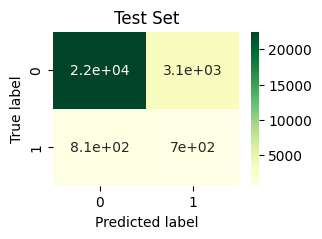

In [345]:
hyperparameters = {
    'rf__n_estimators': [100, 200, 300, 400],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt']
}

model_rf_3, params_rf_3, _, _ = train_crossval_predict_score(
    rf_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

### Ada boost

Accuracy on training set: 0.84
Accuracy on test set: 0.84
----------------------------------------
Recall on training set: 0.46
Recall on test set: 0.44
----------------------------------------
Precision on training set: 0.16
Precision on test set: 0.16
----------------------------------------
fbeta_score on training set: 0.24
fbeta_score on test set: 0.23
----------------------------------------
roc_auc_score on trainig set:  0.78
roc_auc_score on test set:  0.76
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

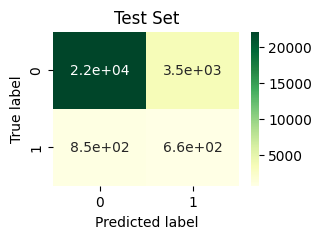

In [346]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('ada', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),  
        random_state=42 
    ))  
])

ada_pipe.fit(X_train, y_train)

y_train_pred = ada_pipe.predict(X_train)
y_test_pred = ada_pipe.predict(X_test)


metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

predict_and_print_scores(ada_pipe, X_train, y_train, X_test, y_test)



/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/milamiletic/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning:

Best params: {'ada__n_estimators': 200, 'ada__learning_rate': 1}
----------------------------------------
Accuracy on training set: 0.85
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.48
Recall on test set: 0.46
----------------------------------------
Precision on training set: 0.18
Precision on test set: 0.18
----------------------------------------
fbeta_score on training set: 0.26
fbeta_score on test set: 0.25
----------------------------------------
roc_auc_score on trainig set:  0.8
roc_auc_score on test set:  0.78
----------------------------------------


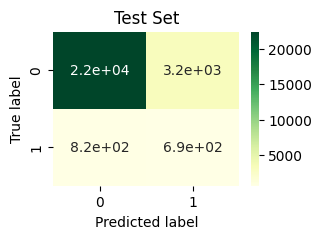

In [347]:
hyperparameters = {
    'ada__n_estimators': [50, 100, 200],  # Number of weak learners to train iteratively
    'ada__learning_rate': [0.01, 0.1, 1],  # Contribution of each classifier
}

model_ada_3, params_ada_3, _, _ = train_crossval_predict_score(
    ada_pipe,
    hyperparameters,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn'
)

### Evaluation

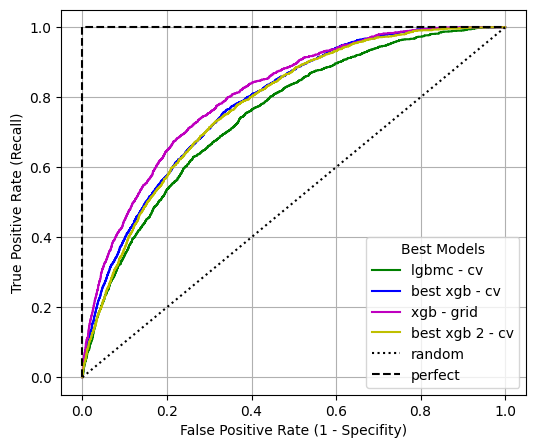

In [512]:
from sklearn.metrics import roc_curve

#fpr_base, tpr_base, thresholds_base = roc_curve(y_test_base, model_lgbmc_b.predict_proba(X_test_base)[:,1])
fpr_lgbmc1, tpr_lgbmc1, thresholds_lgbmc1 = roc_curve(y_test, model_lgbmc_3.predict_proba(X_test)[:,1])
fpr_lgbmc2, tpr_lgbmc2, thresholds_lgbmc2 = roc_curve(y_test, xgb_best_pipe.predict_proba(X_test)[:,1])
fpr_lgbmc3, tpr_lgbmc3, thresholds_lgbmc3 = roc_curve(y_test, model_xgb_6.predict_proba(X_test)[:,1])
fpr_lgbmc4, tpr_lgbmc4, thresholds_lgbmc4 = roc_curve(y_test, model_xgb_4.predict_proba(X_test)[:,1])

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()
#plt.plot(fpr_base, tpr_base,'r-',label = 'lgbmc - base')
plt.plot(fpr_lgbmc1, tpr_lgbmc1,'g-', label= 'lgbmc - cv')
plt.plot(fpr_lgbmc2, tpr_lgbmc2,'b-', label= 'best xgb - cv')
plt.plot(fpr_lgbmc3, tpr_lgbmc3,'m-', label= 'xgb - grid')
plt.plot(fpr_lgbmc4, tpr_lgbmc4,'y-', label= 'best xgb 2 - cv')

plt.plot([0,1],[0,1],'k:',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='perfect')
plt.legend(title='Best Models')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()

In [374]:
def find_roc_threshold_f1(model, X, y):
    pred_ = model.predict_proba(X)[:,1]
    best_threshold = 0.5
    best_score = 0.0
    for value in np.arange(1, 10, 0.5):
        pred_tmp = np.where(pred_ >= float(value/10), 1, 0)
        cost = f1_score(y, pred_tmp)
        if cost > best_score:
            best_score = cost
            best_threshold = float(value/10)
    return best_threshold, best_score

In [511]:
#grid optimized xgb
thr, score = find_roc_threshold_f1(model_xgb_6, X_test, y_test)
print(f"Best threshold: {thr}")
print(f"Best f1 score: {score}")

Best threshold: 0.55
Best f1 score: 0.2929029195347733


In [377]:
def find_roc_threshold_tpr(model, X, y, value_target):
    fpr, tpr, thr = roc_curve(y, model.predict_proba(X)[:,1])
    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff
    return threshold, false_pos_rate

In [510]:
#thr_1, false_pos_rate = find_roc_threshold_tpr(model_xgb_5, X_test, y_test, 0.8)
#grid optimized xgb
thr_1, false_pos_rate = find_roc_threshold_tpr(model_xgb_6, X_test, y_test, 0.8)

print(f"Threshold for tpr of {thr_1}")
print(f"False positive rate: {false_pos_rate}")

Threshold for tpr of 0.3085796535015106
False positive rate: 0.34358633627765184


In [353]:
# Get the LGBMClassifier step from the pipeline
lgbmc_step = model_xgb_3.named_steps['xgb']
# Access feature importances
feature_importances = lgbmc_step.feature_importances_
feature_names = X_train.columns
# Combine feature names and their importances into a dictionary, then sort by importance
importances_dict = dict(zip(feature_names, feature_importances))
sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
# Displaying feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: cons3_min, Importance: 0.1399211883544922
Feature: agent_remark_std, Importance: 0.13028787076473236
Feature: cons1_max, Importance: 0.036274503916502
Feature: counter_coefficient_min, Importance: 0.03217855468392372
Feature: transaction_count, Importance: 0.02724391408264637
Feature: cons1_std, Importance: 0.026413781568408012
Feature: cons3_range, Importance: 0.02509552799165249
Feature: agent_remark_max, Importance: 0.023881688714027405
Feature: cons1_min, Importance: 0.02264074981212616
Feature: cons3_total, Importance: 0.02183074876666069
Feature: ener_std_consumption, Importance: 0.021753419190645218
Feature: ener_mean_invoice_delta, Importance: 0.021522747352719307
Feature: cons3_max, Importance: 0.02053648605942726
Feature: cons2_total, Importance: 0.01985681802034378
Feature: cons2_range, Importance: 0.019838985055685043
Feature: agent_remark_min, Importance: 0.018998747691512108
Feature: ener_max_consumption, Importance: 0.018947521224617958
Feature: cons2_std, Impor

In [416]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(
    estimators=[
        ('lgbmc_cv', model_lgbmc_3), 
        ('rf_cv', model_rf_3), 
        ('xgb_cv', model_xgb_4), 
        ('ada_cv', model_ada_3)
    ],
    voting='hard'
)


voting_clf_hard.fit(X_train, y_train)

# Make predictions
y_pred_hard = voting_clf_hard.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_hard))
print("Recall:", recall_score(y_test, y_pred_hard))
print("Precision:", precision_score(y_test, y_pred_hard))
print("F1 Score:", f1_score(y_test, y_pred_hard))

Accuracy: 0.8727366660106278
Recall: 0.4392070484581498
Precision: 0.20359403716561159
F1 Score: 0.2782196176922003


## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************

In [266]:
## test